# Evaluation of multi-omics GRN inference methods
## Benchmarking of the inferred GRNs
### by Jalil Nourisa



# Imports

In [1]:
# !pip install anndata lightgbm

In [2]:
# !conda install -c conda-forge graph-tool -y 

In [2]:
import os
import gzip
import pandas as pd
import numpy as np
import anndata as ad
from sklearn.model_selection import LeaveOneOut, StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split, LeaveOneGroupOut, KFold
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tqdm
import scipy
import json
# import category_encoders as ce
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from scipy.sparse import csr_matrix
import lightgbm
import matplotlib
import sys
import requests

sys.path.insert(0, '../')
from src.commons import work_dir, COLORS, surragate_names, LINESTYLES, MARKERS, colors_cell_type, colors_blind

matplotlib.rc('font', family='serif')
matplotlib.rc('text', usetex='false')

%matplotlib inline

input_dir = '../input/'
results_folder = '../results_folder/'
os.makedirs(f'{work_dir}', exist_ok=True)

# Create explanatory data

In [ ]:
bulk_adata = ad.read_h5ad(f'{input_dir}/perturbation_data.h5ad')
prior_adata.uns['gene_names_pert'] = bulk_adata.var_names.to_numpy()

bulk_adata = ad.read_h5ad(f'{input_dir}/multiomics_rna.h5ad')
prior_adata.uns['gene_names'] = bulk_adata.var_names.to_numpy()

bulk_adata = ad.read_h5ad(f'{input_dir}/multiomics_atac.h5ad')
prior_adata.uns['peak'] = bulk_adata.var_names.to_numpy()

tf_list = np.loadtxt("https://resources.aertslab.org/cistarget/tf_lists/allTFs_hg38.txt", dtype=str)



url = "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_46/gencode.v46.annotation.gtf.gz"
local_filename = f'{input_dir}/gencode.v46.annotation.gtf.gz'

with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)


## HVGs

In [ ]:
#hvgs


In [18]:
%load_ext rpy2.ipython

In [ ]:
%%R -i input_dir 
library(scry)
library(zellkonverter)
library(SingleCellExperiment)
options(digits=5, max.print=100)  # Adjust numbers as needed



adata = readH5AD(paste0(input_dir, "/bulk_adata_integrated.h5ad")) # raw counts
multiomics_rna <- readH5AD(paste0(input_dir, "/adata_rna.h5ad"))

# Extract the gene names from multiomics_rna
multiomics_genes <- rownames(multiomics_rna)

# Subset adata to keep only the genes present in multiomics_rna
adata <- adata[rownames(adata) %in% multiomics_genes, ]

adata_sce = devianceFeatureSelection(adata, assay="X", batch=colData(adata)$plate_name)

binomial_deviance <- rowData(adata_sce)$binomial_deviance

# Sort the indices of binomial deviance in decreasing order and select the top `n_hvgs`
indices <- order(binomial_deviance, decreasing = TRUE)[1:par$n_hvgs]

# Create a mask
mask <- rep(FALSE, length(binomial_deviance))
mask[indices] <- TRUE

# Select the highly variable genes
hvgs_sce <- rownames(adata_sce)[mask]

# Save the highly variable genes to a text file
# print(hvgs_sce)

write(hvgs_sce, file = paste0(input_dir, "/hvgs.txt"))


## Gene annotation

In [6]:
# gene annotation
from local_utils import annotation

multiomics_genes =  np.loadtxt(f'{input_dir}/multiomics_genes.txt', dtype=str)
annot_database = annotation.ensembl_gene_annotation()
annot_database = annot_database[annot_database.Gene.isin(multiomics_genes)] 
annot_database = annot_database[annot_database.Chromosome.astype(str).isin([str(i+1) for i in range(21)]+['X', 'Y'])] # only valid chr
annot_database = annot_database[['Gene', 'Transcript_type']].drop_duplicates()

annot_database.Transcript_type.value_counts()
annot_database.to_csv(f'{input_dir}/gene_annotation.csv')

In [7]:

# annot_database = annot_database[annot_database.Transcript_type.isin(['protein_coding', 'processed_transcript', 'nonsense_mediated_decay'])]

# annot_database = annot_database.drop_duplicates(['Gene', 'Transcript_type'])




In [8]:

# transcript_types = ['protein_coding', 'lncRNA', 'miRNA']

# annot_database_f = annot_database[annot_database.Gene.isin(multiomics_genes)].reset_index()

# annot_database_f = annot_database_f[['Gene', 'Transcript_type']].drop_duplicates()
# annot_database_f = annot_database_f[annot_database_f.Transcript_type.isin(transcript_types)]
# rename_map = {'protein_coding':'Protein coding', 'lncRNA':'LncRNA',  'miRNA':'MicroRNA'}
# annot_database_f.Transcript_type = annot_database_f.Transcript_type.map(rename_map)
# annot_database_f.reset_index(drop=True, inplace=True)
# annot_database_f.head()
#  #only keep genes with one annotation
# annot_size = annot_database_f.groupby('Gene').size()
# kept_genes = annot_size[~(annot_size>1)].index
# annot_database_f = annot_database_f[annot_database_f.Gene.isin(kept_genes)].reset_index(drop=True)
# #save 
# annot_database_f.to_csv(f'{input_dir}/gene_annotation.csv')

In [42]:
%load_ext rpy2.ipython

## Peak annotation

In [62]:
%%R -i input_dir
options(digits=5, max.print=100)  # Adjust numbers as needed
set.seed(123)

library(IRanges)
library(GenomicRanges)
library(ggplot2)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(dplyr)
library(stringr)
library(anndata)
library(tibble)

# Read the .h5ad file
adata_atac <- read_h5ad(paste0(input_dir, "/adata_atac.h5ad"))

format_peak <- function(peaks) {
  formatted_peaks <- vector("character", length(peaks))
  for (i in seq_along(peaks)) {
    parts <- unlist(strsplit(peaks[i], "[:\\-_]"))
    chr <- parts[1]
    peak <- parts[2]
    # end <- parts[3]
    # print(start)
    # aa
    formatted_peaks[i] <- paste0(chr, ":", peak)
  }
  return(formatted_peaks)
}

# Get the peak names and format them
atac_peaks <- format_peak(rownames(adata_atac$var))

# Create a data frame with chromosome and range information
peaks <- tibble(
  chr = sapply(atac_peaks, function(x) strsplit(x, ":")[[1]][1]),
  range = sapply(atac_peaks, function(x) paste(strsplit(x, ":")[[1]][2], collapse = ""))
)

txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene
peaks = GRanges(peaks$chr, IRanges(peaks$range))
peaks_annotated = suppressMessages(ChIPseeker::annotatePeak(
    peaks,
    tssRegion = c(-1000, 1000), # extended from -5kb to 5
    TxDb = txdb,
    level = "transcript", 
    assignGenomicAnnotation = TRUE,  # the default
    genomicAnnotationPriority = c("Promoter", "5UTR", "3UTR", "Exon", "Intron",
                                "Downstream", "Intergenic"),  # the default
    annoDb = NULL,
    sameStrand = FALSE, # the default
    ignoreOverlap = FALSE, # the default
    ignoreUpstream = FALSE, # the default
    ignoreDownstream = FALSE, # the default
    overlap = "TSS", # the default
    verbose = TRUE # the default
))
peaks_annotated_df = as.data.frame(peaks_annotated)

# Define the mapping dictionary
map_ <- c('Intron' = 'Intron', 
          'Exon' = 'Exon', 
          'Promoter' = 'Promoter', 
          'Distal' = 'Distal Intergenic', 
          "3'" = "3' UTR", 
          'Downstream' = 'Downstream (<=300)', 
          "5'" = "5' UTR")

# Split the annotation column and map the values
peaks_annotated_df$ann <- sapply(str_split(peaks_annotated_df$annotation, ' ', simplify = TRUE)[, 1], function(x) map_[x])

# # Create the peaks string
peaks_annotated_df$peaks <- paste0(peaks_annotated_df$seqnames, ':', peaks_annotated_df$start, '-', peaks_annotated_df$end)

# # Create a new data frame with the required columns
df <- data.frame(annotation = peaks_annotated_df$ann, peak = peaks_annotated_df$peaks, stringsAsFactors = FALSE)

write.csv(df, file = paste0(input_dir, "/peak_annotation.csv"), row.names = FALSE)



/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/root/anaconda3/envs/py10/lib/python3.10/site-packages/rpy2/rinterface.py:186: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  openrlib.rlib.R_tryEval(


>> preparing features information...		 2024-07-29 13:36:09 
>> identifying nearest features...		 2024-07-29 13:36:09 
>> calculating distance from peak to TSS...	 2024-07-29 13:36:10 
>> assigning genomic annotation...		 2024-07-29 13:36:10 
>> assigning chromosome lengths			 2024-07-29 13:36:15 
>> done...					 2024-07-29 13:36:15 


# Explanatory analysis 

In [3]:
# load all
hvgs = np.loadtxt( f'{input_dir}/hvgs.txt', dtype=str)
pert_genes = np.loadtxt(f'{input_dir}/perturb_gene_names.txt', dtype=str)
multiomics_genes = np.loadtxt(f'{input_dir}/multiomics_genes.txt', dtype=str)
gene_annotation_df = pd.read_csv(f'{input_dir}/gene_annotation.csv')
peak_annotation_df = pd.read_csv(f'{input_dir}/peak_annotation.csv')
# housekeeping genes
housekeeping_genes = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)
housekeeping_genes = housekeeping_genes.loc[:, 0]  # Gene names
housekeeping_genes = np.intersect1d(housekeeping_genes, pert_genes)
print(f'Number of housekeeping genes: {len(housekeeping_genes)}')

Number of housekeeping genes: 3513


In [4]:
grn_model_names = ['collectRI', 'figr', 'celloracle', 'granie', 'scglue', 'scenicplus']

n_nets = len(grn_model_names)

grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'{work_dir}/benchmark/grn_models/{name}.csv', index_col=0)

grn_models_dict = {surragate_names[name]:grn for name, grn in grn_models_dict.items()}

In [5]:
peak_gene_model = ['figr', 'celloracle', 'granie']

grn_peak_gene_dict = {}
for name in peak_gene_model:
    model = pd.read_csv(f'../output/benchmark/peak_gene_models/{name}.csv', index_col=0)
    model.peak = model.source.str.replace('_','-')
    model.peak = model.source.str.replace(':','-')
    grn_peak_gene_dict[name] = model
grn_peak_gene_dict = {surragate_names[name]:grn for name, grn in grn_peak_gene_dict.items()}

/tmp/ipykernel_1471/1062260597.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  model.peak = model.source.str.replace('_','-')
/tmp/ipykernel_1471/1062260597.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  model.peak = model.source.str.replace('_','-')
/tmp/ipykernel_1471/1062260597.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  model.peak = model.source.str.replace('_','-')


## Data structure 

In [6]:
from src.explanatory_analysis import Explanatory_analysis

info_objs_dict = {}
for name in grn_models_dict.keys():
    print(name)
    net = grn_models_dict[name]
    net_peak_gene = grn_peak_gene_dict.get(name, None)

    info_obj = Explanatory_analysis(net=net, peak_gene_net=net_peak_gene)

    info_objs_dict[name] = info_obj

    print(info_objs_dict[name].annotate_genes(gene_annotation_df))

CollectRI
{'protein_coding': 78.2, 'processed_transcript': 47.6, 'retained_intron': 46.2, 'nonsense_mediated_decay': 32.4, 'Rest': 0.7}
FigR
{'protein_coding': 90.5, 'processed_transcript': 54.2, 'retained_intron': 50.0, 'nonsense_mediated_decay': 36.2, 'lncRNA': 6.2, 'Rest': 0.9}
CellOracle
{'protein_coding': 93.9, 'processed_transcript': 62.3, 'retained_intron': 59.0, 'nonsense_mediated_decay': 45.1, 'lncRNA': 3.2, 'Rest': 1.0}
GRANIE
{'protein_coding': 95.2, 'processed_transcript': 57.3, 'retained_intron': 56.1, 'nonsense_mediated_decay': 40.4, 'Rest': 0.8}
scGLUE
{'protein_coding': 85.4, 'processed_transcript': 51.8, 'retained_intron': 47.5, 'nonsense_mediated_decay': 34.3, 'lncRNA': 11.1, 'Rest': 1.7}
Scenic+
{'protein_coding': 96.7, 'processed_transcript': 59.6, 'retained_intron': 56.5, 'nonsense_mediated_decay': 42.9, 'Rest': 0.9}


## Topological analysis

### General stats

In [7]:
# regulatory links
links_n = {}
for name, grn in grn_models_dict.items():
    if 'cell_type' in grn.columns: # for cell specific grn models, take the mean
        n_grn = grn.groupby('cell_type').size().mean()
    else:
        n_grn = len(grn)
    links_n[name] = n_grn
print(links_n)

# positive vs negative
regulatory_effect_dict = {}
for name, grn in grn_models_dict.items():
    print('-----', name)
    grn_sign = grn.copy()
    weights = grn_sign.weight
    weights = [1 if weight>0 else -1 for weight in weights]
    grn_sign.weight = weights
    if 'cell_type' in grn.columns:
        celltype_counts = grn_sign.groupby('cell_type').weight.value_counts()
        signs = [celltype_counts[celltype_counts.index.get_level_values('weight')==1].mean(), celltype_counts[celltype_counts.index.get_level_values('weight')==-1].mean()]
    else:
        signs = grn_sign.weight.value_counts().values # 'positive, negative:
    if len(signs)==1:
        signs = [signs[0], 0]
    regulatory_effect_dict[name] = signs
regulatory_effect_dict
# tfs and targets
target_genes_dict = {}
tfs_dict = {}
for name, grn in grn_models_dict.items():
    grn = grn[grn.target.isin(multiomics_genes)]
    tfs_dict[name] = grn.source.unique() 
    target_genes_dict[name] = grn.target.unique().tolist()


print('number of TFs')
tfs_dict_n =  {key:len(values) for key,values in tfs_dict.items()}
print(tfs_dict_n)
print('number of targets')
target_genes_dict_n = {key:len(values) for key,values in target_genes_dict.items()}
target_genes_dict_n

# peaks
peaks_dict = {}
peaks_n_dict = {}
for name, df in grn_peak_gene_dict.items():
    peaks_dict[name] = df.source.unique()
    peaks_n_dict[name] = df.source.nunique()

{'CollectRI': 43178, 'FigR': 24292, 'CellOracle': 155323, 'GRANIE': 10679, 'scGLUE': 51567, 'Scenic+': 33537}
----- CollectRI
----- FigR
----- CellOracle
----- GRANIE
----- scGLUE
----- Scenic+
number of TFs
{'CollectRI': 1133, 'FigR': 389, 'CellOracle': 557, 'GRANIE': 180, 'scGLUE': 439, 'Scenic+': 139}
number of targets


#### Plot

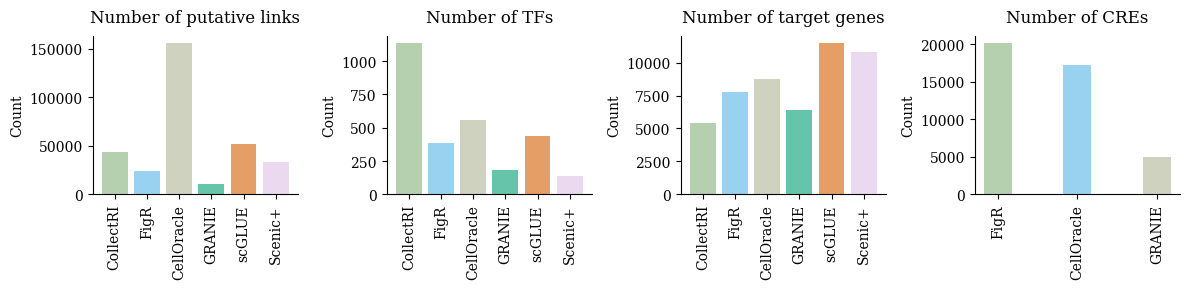

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3)) 
color = 'grey'
## number of links
ax = axes[0]
colors = [COLORS[name] for name in links_n.keys()]
ax.bar(links_n.keys(), links_n.values(), color=colors,  alpha=.6)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of putative links', pad=10)
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
# ax.set_yscale('log')

# Rotate category names for better readability
plt.xticks(rotation=45)
## number of TFs
ax = axes[1]
ax.bar(tfs_dict_n.keys(), tfs_dict_n.values(), color=colors,  alpha=.6)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of TFs', pad=10)
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
# ax.set_yscale('log')
## number of target 
ax = axes[2]

ax.bar(target_genes_dict_n.keys(), target_genes_dict_n.values(), color=colors,  alpha=.6)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of target genes', pad=10)
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
# ax.set_yscale('log')
plt.tight_layout()

## number of peaks 
ax = axes[3]
colors = [COLORS[name] for name in links_n.keys()]
ax.bar(peaks_n_dict.keys(), peaks_n_dict.values(), color=colors, width=0.35, alpha=.6)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of CREs', pad=10)
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
# ax.set_yscale('log')
plt.tight_layout()

fig.savefig(f'{results_folder}/explanatory_analysis/figs/stats_regulatory_elements.png', dpi=150, transparent=True)

#### Regulatory signs

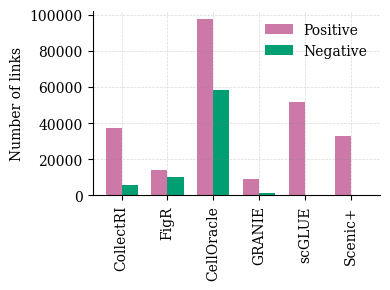

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3)) 
# regulatory role 
data = regulatory_effect_dict
categories = list(data.keys())
positive_counts = [data[category][0] for category in categories]
negative_counts = [data[category][1] for category in categories]
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
bars1 = ax.bar(x - width/2, positive_counts, width, label='Positive', color=colors_blind[6])
bars2 = ax.bar(x + width/2, negative_counts, width, label='Negative', color=colors_blind[2])
ax.set_ylabel('Number of links')
# ax.set_title('Regulatory sign')
ax.set_xticks(x)
# ax.set_scale('log')
ax.set_xticklabels(categories)
# ax.set_xticklabels([category for category in categories])
ax.tick_params(axis='x', rotation=90)
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.grid(alpha=0.3, linestyle='--', linewidth=.5, color='grey')
# ax.set_yscale('log')
ax.legend(frameon=False)
plt.tight_layout()
fig.savefig(f'{results_folder}/explanatory_analysis/figs/regulatory_signs.png', dpi=300, transparent=True)

### Connectivity

#### Centrality

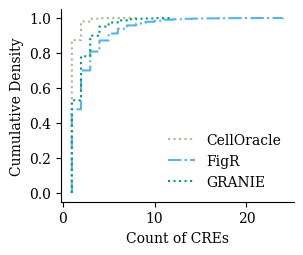

In [10]:
# peak gene: in degree
def plot_cumulative_density(data, title='', x_label='Number of CREs', ax=None, s=1, **kwdgs):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

    ax.step(sorted_data, cdf, where='post', label=title, **kwdgs)

    ax.set_xlabel(x_label)
    ax.set_ylabel('Cumulative Density')
    ax.spines[['top','right']].set_visible(False)
    # ax.grid(True)
    return fig, ax

fig, ax = plt.subplots(figsize=(3, 2.5))
for i_plot, name in enumerate(['CellOracle','FigR','GRANIE']):
    info_objs_dict[name].calculate_centrality_stats()
    values = info_objs_dict[name].peak_gene.in_deg
    plot_cumulative_density(values, title=name, x_label='Count of CREs', ax=ax, linestyle=LINESTYLES[name], c=COLORS[name])
ax.legend(frameon=False)
fig.savefig(f'{results_folder}/explanatory_analysis/figs/centrality_peakgene.png', dpi=300, transparent=True)
# ax.set_title('In-degree centrality: CRE-gene', pad=20)

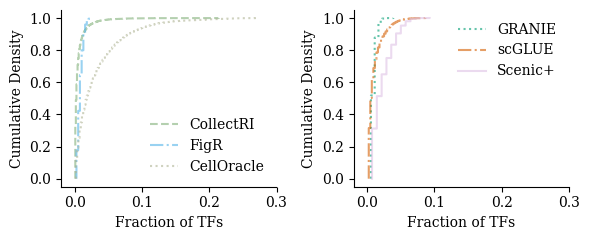

In [11]:
# tf gene: in degree
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))
for i_plot, name in enumerate(grn_models_dict.keys()):
    info_objs_dict[name].calculate_centrality_stats()
    values = info_objs_dict[name].tf_gene.in_deg

    if i_plot < 3:
        ax = axes[0]
    else:
        
        ax = axes[1]
    plot_cumulative_density(values, title=name,x_label='Fraction of TFs', ax=ax, linestyle=LINESTYLES[name], c=COLORS[name], alpha=.6)
    ax.legend(frameon=False)
    ax.set_xlim([-.02,.3])
    # ax.set_title('(a) In-degree centrality: TF-gene', pad=20)
plt.tight_layout()
fig.savefig(f'{results_folder}/explanatory_analysis/figs/centrality_in.png', dpi=300, transparent=True)

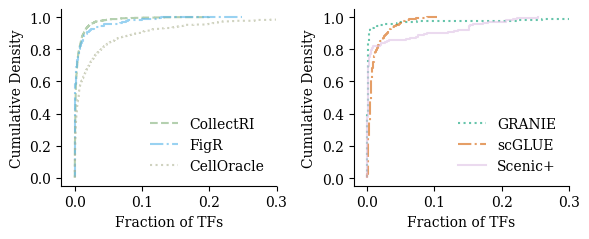

In [12]:
# tf gene: out degree 
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))
for i_plot, name in enumerate(grn_models_dict.keys()):
    info_objs_dict[name].calculate_centrality_stats()
    values = info_objs_dict[name].tf_gene.out_deg

    if i_plot < 3:
        ax = axes[0]
    else:
        
        ax = axes[1]
    plot_cumulative_density(values, title=name,x_label='Fraction of TFs', ax=ax, linestyle=LINESTYLES[name], c=COLORS[name], alpha=.6)
    ax.legend(frameon=False)
    ax.set_xlim([-.02,.3])
    # ax.set_title('(a) In-degree centrality: TF-gene', pad=20)
plt.tight_layout()
fig.savefig(f'{results_folder}/explanatory_analysis/figs/centrality_out.png', dpi=300, transparent=True)

### Intersection of GRN elements

In [13]:
# Create a set of all unique genes
def normalize_formatize_interactions(data_dict):
    all_cases = list(set(item for items in data_dict.values() for item in items))
    
    # Initialize DataFrame
    df = pd.DataFrame(index=all_cases)
    # Populate DataFrame
    for key, items in data_dict.items():
        df[key] = df.index.isin(items)
    return df

In [14]:
multiomics_genes = np.loadtxt(f'{input_dir}/multiomics_genes.txt', dtype=str)
grn_fused_dict = {}
for name, grn in grn_models_dict.items():
    
    grn = grn[grn.target.isin(multiomics_genes)]
    grn['link'] = grn['source'] + '_' + grn['target']
    grn_fused_dict[name] = grn['link'].drop_duplicates().reset_index(drop=True)

/tmp/ipykernel_1471/239520411.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grn['link'] = grn['source'] + '_' + grn['target']
/tmp/ipykernel_1471/239520411.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grn['link'] = grn['source'] + '_' + grn['target']
/tmp/ipykernel_1471/239520411.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [15]:
del target_genes_dict['CollectRI']
del grn_fused_dict['CollectRI']
del tfs_dict['CollectRI']

In [16]:
(normalize_formatize_interactions(grn_fused_dict).sum(axis=1)==(len(grn_fused_dict))).sum()

4

 ####### links


/root/anaconda3/envs/py10/lib/python3.10/site-packages/upsetplot/plotting.py:797: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/root/anaconda3/envs/py10/lib/python3.10/site-packages/upsetplot/plotting.py:798: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

['CellOracle', 'scGLUE', 'Scenic+', 'FigR', 'GRANIE']


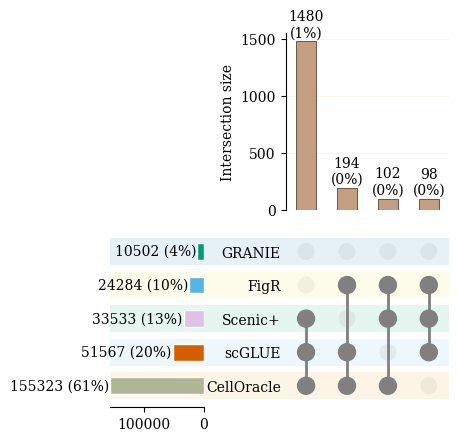

In [17]:
import upsetplot

print(' ####### links')
fig = plt.figure()
df_interactions = normalize_formatize_interactions(grn_fused_dict)
out_dict = upsetplot.plot(upsetplot.from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='cardinality', 
        # min_subset_size =".1%", # min interaction to show
        min_subset_size = 70, # min interaction to show
        min_degree=3,
        facecolor='grey',
        other_dots_color=.1, 
        shading_color =.01, 
        with_lines = True,
        element_size = 35,
        intersection_plot_elements=5,
        totals_plot_elements = 2
        )
# Loop through each bar and change its face color


matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']

methods_order = [label.get_text() for label in matrix_ax.get_yticklabels()]
# methods_order.reverse()
print(methods_order)
for i_bar, bar in enumerate(totals_ax.patches):
    bar.set_facecolor(COLORS[methods_order[i_bar]])
    bar.set_edgecolor('white')

for bar in intersections_ax.patches:
    bar.set_facecolor(colors_cell_type[2])
    bar.set_edgecolor('black')
    bar.set_linewidth(.4)

for bar, new_color in zip(shading_ax.patches, colors_blind):
    bar.set_facecolor(new_color)
    bar.set_alpha(.1)
    bar.set_edgecolor('black')

plt.subplots_adjust(wspace=-.4)  # Example adjustment, modify as needed


fig.savefig(f'{results_folder}/explanatory_analysis/figs/links_interactions.png', dpi=300, transparent=True,  bbox_inches='tight')
# plt.show()

 ####### TFs
['CellOracle', 'scGLUE', 'FigR', 'GRANIE', 'Scenic+']


/root/anaconda3/envs/py10/lib/python3.10/site-packages/upsetplot/plotting.py:797: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/root/anaconda3/envs/py10/lib/python3.10/site-packages/upsetplot/plotting.py:798: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

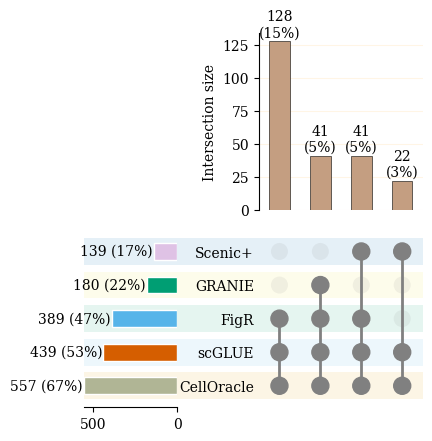

In [18]:
print(' ####### TFs')
fig = plt.figure()
df_interactions = normalize_formatize_interactions(tfs_dict)
out_dict = upsetplot.plot(upsetplot.from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='cardinality', 
        min_subset_size =22, # min interaction to show
        min_degree=3,
        facecolor='grey',
        other_dots_color=.1, 
        shading_color =.01, 
        with_lines = True,
        element_size = 35,
        intersection_plot_elements=5,
        totals_plot_elements = 2
        )
# Loop through each bar and change its face color


matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
methods_order = [label.get_text() for label in matrix_ax.get_yticklabels()]
# methods_order.reverse()
print(methods_order)
for i_bar, bar in enumerate(totals_ax.patches):
    bar.set_facecolor(COLORS[methods_order[i_bar]])
    bar.set_edgecolor('white')

for bar in intersections_ax.patches:
    bar.set_facecolor(colors_cell_type[2])
    bar.set_edgecolor('black')
    bar.set_linewidth(.4)

for bar, new_color in zip(shading_ax.patches, colors_blind):
    bar.set_facecolor(new_color)
    bar.set_alpha(.1)
    bar.set_edgecolor('black')

plt.subplots_adjust(wspace=-.4)  # Example adjustment, modify as needed


fig.savefig(f'{results_folder}/explanatory_analysis/figs/TFs_interactions.png', dpi=300, transparent=True, bbox_inches='tight')
# plt.show()

 ####### target genes
['scGLUE', 'Scenic+', 'CellOracle', 'FigR', 'GRANIE']


/root/anaconda3/envs/py10/lib/python3.10/site-packages/upsetplot/plotting.py:797: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/root/anaconda3/envs/py10/lib/python3.10/site-packages/upsetplot/plotting.py:798: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

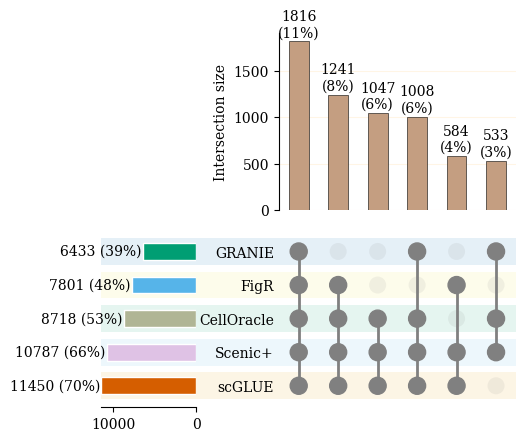

In [19]:

print(' ####### target genes')
fig = plt.figure(figsize=(4, 3.5))
df_interactions = normalize_formatize_interactions(target_genes_dict)
out_dict = upsetplot.plot(upsetplot.from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='cardinality', 
        min_subset_size = 500, # min interaction to show
        min_degree=3,
        facecolor=colors_cell_type[4],
        other_dots_color=.1, 
        shading_color =.01, 
        with_lines = True,
        element_size = 35,
        intersection_plot_elements=5,
        totals_plot_elements = 2
        )
# Loop through each bar and change its face color


matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
methods_order = [label.get_text() for label in matrix_ax.get_yticklabels()]
print(methods_order)
for i_bar, bar in enumerate(totals_ax.patches):
    bar.set_facecolor(COLORS[methods_order[i_bar]])
    bar.set_edgecolor('white')

for bar in intersections_ax.patches:
    bar.set_facecolor(colors_cell_type[2])
    bar.set_edgecolor('black')
    bar.set_linewidth(.4)

for bar, new_color in zip(shading_ax.patches, colors_blind):
    bar.set_facecolor(new_color)
    bar.set_alpha(.1)
    bar.set_edgecolor('black')

plt.subplots_adjust(wspace=-.4)  # Example adjustment, modify as needed
plt.tight_layout()

fig.savefig(f'{results_folder}/explanatory_analysis/figs/targets_interactions.png', dpi=300, transparent=True, bbox_inches='tight')

 ####### CREs
['FigR', 'CellOracle', 'GRANIE']


/root/anaconda3/envs/py10/lib/python3.10/site-packages/upsetplot/plotting.py:797: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/root/anaconda3/envs/py10/lib/python3.10/site-packages/upsetplot/plotting.py:798: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

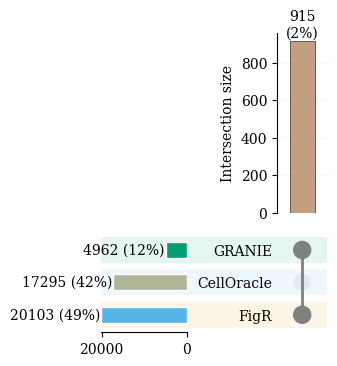

In [20]:
print(' ####### CREs')
fig = plt.figure(figsize=(4, 3.5))
df_interactions = normalize_formatize_interactions(peaks_dict)
out_dict = upsetplot.plot(upsetplot.from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='cardinality', 
        # min_subset_size = 500, # min interaction to show
        min_degree=2,
        facecolor=colors_cell_type[4],
        other_dots_color=.1, 
        shading_color =.01, 
        with_lines = True,
        element_size = 35,
        intersection_plot_elements=5,
        totals_plot_elements = 2
        )

matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
methods_order = [label.get_text() for label in matrix_ax.get_yticklabels()]
print(methods_order)
for i_bar, bar in enumerate(totals_ax.patches):
    bar.set_facecolor(COLORS[methods_order[i_bar]])
    bar.set_edgecolor('white')

for bar in intersections_ax.patches:
    bar.set_facecolor(colors_cell_type[2])
    bar.set_edgecolor('black')
    bar.set_linewidth(.4)

for bar, new_color in zip(shading_ax.patches, colors_blind):
    bar.set_facecolor(new_color)
    bar.set_alpha(.1)
    bar.set_edgecolor('black')

plt.subplots_adjust(wspace=-.3)  # Example adjustment, modify as needed


fig.savefig(f'{results_folder}/explanatory_analysis/figs/cres_interactions.png', dpi=300, transparent=True, bbox_inches='tight')

## Annoation

### Annotate peaks

#### Plot

In [21]:
annotation_dict = {}
for name in grn_peak_gene_dict.keys():
    annotation_dict[name] = info_objs_dict[name].annotate_peaks(peak_annotation_df)
peak_annotation_df = pd.DataFrame.from_dict(annotation_dict, orient='index')
threshold = 1 # remove below this raction
peak_annotation_df = peak_annotation_df.loc[:, (peak_annotation_df>threshold).sum(axis=0)!=0]
peak_annotation_df

,Intron,Promoter,Distal Intergenic,Exon,3' UTR,Downstream (<=300)
FigR,37.0,31.0,18.6,6.6,4.5,1.6
CellOracle,0.6,98.5,0.3,0.2,0.1,0.0
GRANIE,25.8,50.8,14.2,5.0,2.8,1.0


/tmp/ipykernel_1471/3149048919.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if counts[j] == 0:
/tmp/ipykernel_1471/3149048919.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if counts[j] > 1:
/tmp/ipykernel_1471/3149048919.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = f'{counts[j]:.1f} %'


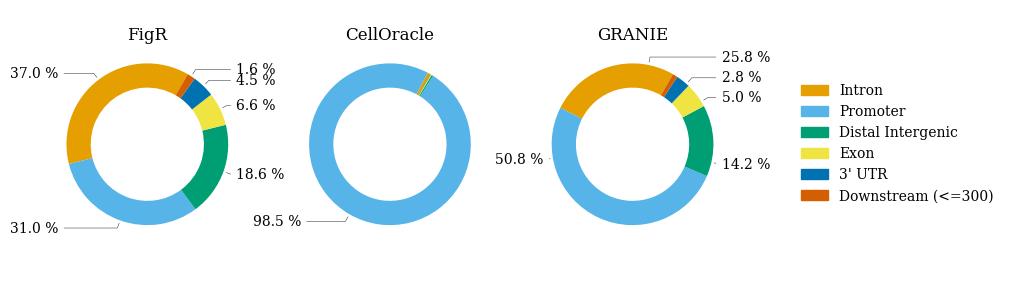

In [22]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(1, len(peak_annotation_df.index) + 1, figsize=(12, 3.5))

colors = colors_blind
startangle = 60

theta_offsets = [2 , 2, 5]
for i, (ax, idx) in enumerate(zip(axes[:-1], peak_annotation_df.index)):
    ax.set_title(idx, fontsize=12, pad=0)
    counts = peak_annotation_df.loc[idx]
    wedges, texts = ax.pie(counts, colors=colors, wedgeprops=dict(width=0.3), startangle=startangle, radius=1)

    bbox_props = dict(fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-", linewidth=0.3), zorder=0, va="center", fontsize=10)

    for j, p in enumerate(wedges):
        if counts[j] == 0:
            continue
        ang = (p.theta2 - p.theta1) / theta_offsets[i] + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        if counts[j] > 1:
            text = f'{counts[j]:.1f} %'
            ax.annotate(text, xy=(x, y), xytext=(1.1 * np.sign(x), 1.1 * y),
                        horizontalalignment=horizontalalignment, **kw)

# Create a legend in the last subplot
ax = axes[-1]
patches = [mpatches.Patch(color=color, label=name) for color, name in zip(colors, peak_annotation_df.columns)]
leg = ax.legend(handles=patches, bbox_to_anchor=(1.15, 0.77), fontsize=10)
leg.get_frame().set_linewidth(0.0)
ax.axis('off')

# plt.tight_layout()
# plt.show()
fig.savefig(f'{results_folder}/explanatory_analysis/figs/peak_annotation.png', dpi=300, transparent=True, bbox_inches='tight')


### Annotate genes

In [23]:
annotation_dict = {}
for name in grn_models_dict.keys():
    annotation_dict[name] = info_objs_dict[name].annotate_genes(gene_annotation_df)
annotation_df = pd.DataFrame.from_dict(annotation_dict, orient='index')
annotation_df = annotation_df.fillna(0)
annotation_df

,protein_coding,processed_transcript,retained_intron,nonsense_mediated_decay,Rest,lncRNA
CollectRI,78.2,47.6,46.2,32.4,0.7,0.0
FigR,90.5,54.2,50.0,36.2,0.9,6.2
CellOracle,93.9,62.3,59.0,45.1,1.0,3.2
GRANIE,95.2,57.3,56.1,40.4,0.8,0.0
scGLUE,85.4,51.8,47.5,34.3,1.7,11.1
Scenic+,96.7,59.6,56.5,42.9,0.9,0.0


In [32]:
from src.explanatory_analysis import annotate_genes
annotate_genes(pert_genes,gene_annotation_df)

Transcript_type
protein_coding             74.2
processed_transcript       46.1
retained_intron            44.5
nonsense_mediated_decay    33.4
lncRNA                     11.4
Rest                        1.5
Name: count, dtype: float64

/tmp/ipykernel_1471/61788092.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if counts[j] == 0:
/tmp/ipykernel_1471/61788092.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if counts[j] > 1:
/tmp/ipykernel_1471/61788092.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = f'{counts[j]:.1f} %'


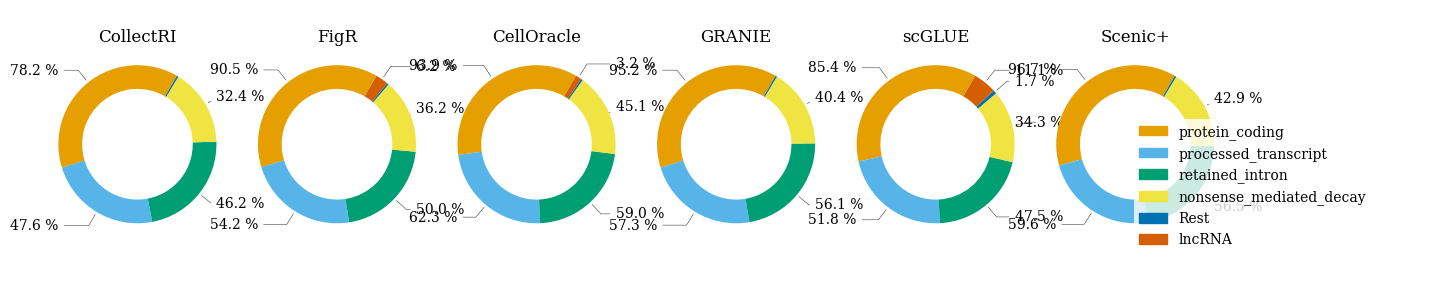

In [24]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(1, len(annotation_df.index) + 1, figsize=(len(annotation_df.index)*3, 3.5))

colors = colors_blind
startangle = 60

theta_offsets = [2 , 2, 2, 2 , 2, 2, 2 , 2, 2]
for i, (ax, idx) in enumerate(zip(axes[:-1], annotation_df.index)):
    ax.set_title(idx, fontsize=12, pad=-.5)
    counts = annotation_df.loc[idx]
    wedges, texts = ax.pie(counts, colors=colors, wedgeprops=dict(width=0.3), startangle=startangle, radius=1)

    bbox_props = dict(fc="w", ec="k", lw=0.7)
    kw = dict(arrowprops=dict(arrowstyle="-", linewidth=0.3), zorder=0, va="center", fontsize=10)

    for j, p in enumerate(wedges):
        if counts[j] == 0:
            continue
        ang = (p.theta2 - p.theta1) / theta_offsets[i] + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        if counts[j] > 1:
            text = f'{counts[j]:.1f} %'
            ax.annotate(text, xy=(x, y), xytext=(1 * np.sign(x), 1.2 * y),
                        horizontalalignment=horizontalalignment, **kw)

# Create a legend in the last subplot
ax = axes[-1]
patches = [mpatches.Patch(color=color, label=name) for color, name in zip(colors, annotation_df.columns)]
leg = ax.legend(handles=patches, bbox_to_anchor=(.72, 0.62), fontsize=10)
leg.get_frame().set_linewidth(0.0)
ax.axis('off')
plt.subplots_adjust(wspace=0.01)  # Adjust horizontal space between subplots

# plt.tight_layout()
# plt.show()
# fig.savefig(f'{results_folder}/explanatory_analysis/figs/gene_annotation.png', dpi=300, transparent=True, bbox_inches='tight')

## HVGs analysis


In [25]:
bulk_adata = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_integrated.h5ad')

n_hvgs = 3000

In [26]:
hvgs_sce = np.loadtxt( f'{input_dir}/hvgs.txt', dtype=str)

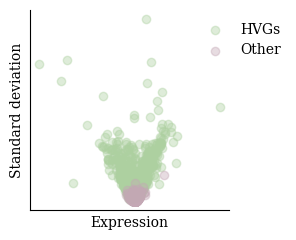

In [27]:
genes = hvgs_sce
bulk_adata.X = bulk_adata.layers['scgen_pearson']
fig, ax = plt.subplots(1, 1, figsize=(3, 2.5), sharey=False)    
var = bulk_adata.var
var['sum'] = bulk_adata.X.sum(axis=0)
var['std'] = bulk_adata.X.std(axis=0)
mask = var.index.isin(genes)
ax.scatter(var['sum'][mask], var['std'][mask], label='HVGs', alpha=0.4, color='#add0a0')
ax.scatter(var['sum'][~mask], var['std'][~mask], label='Other', alpha=0.4, color='#c4a8b5')


ax.set_ylabel('Standard deviation')
ax.set_xlabel('Expression')
# ax.set_xscale('log')
# ax.set_yscale('log')


for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
# ax.grid(alpha=0.3, linestyle='--', linewidth=1, color='grey')


ax.legend(title='', loc='upper left', bbox_to_anchor=(.8, 1), frameon=False)

plt.tight_layout()
fig.savefig(f'{results_folder}/explanatory_analysis/figs/hvgs_sum_std.png', dpi=150, transparent=True)

### GRN targets vs HVGs 

In [28]:
hvgs = hvgs_sce

n_included_hvgs_dict = {}
n_included_hvgs_ratio_dict = {}
pr_dict = {}
for name in grn_models_dict.keys():
    info = info_objs_dict[name].calculate_hvgs_stats(hvgs, pert_genes)

    n_included_hvgs_dict[name] = round(100*info['n_included_hvgs']/n_hvgs,1)
    n_included_hvgs_ratio_dict[name] = info['ratio']

    pr_dict[name] = info['percentile_rank']

n_included_hvgs_ratio_dict

{'CollectRI': 0.35361216730038025,
 'FigR': 0.3113473999003157,
 'CellOracle': 0.30652304009575104,
 'GRANIE': 0.28865979381443296,
 'scGLUE': 0.32648343180066786,
 'Scenic+': 0.28259695365669224}

In [29]:
from src.explanatory_analysis import calculate_hvgs_stats
info =  calculate_hvgs_stats(housekeeping_genes, hvgs, pert_genes)
n_included_hvgs_dict['HKGs'] = round(100*info['n_included_hvgs']/n_hvgs,1)
n_included_hvgs_ratio_dict['HKGs'] = info['ratio']

pr_dict['HKGs'] = info['percentile_rank']


In [30]:
n_included_hvgs_dict

{'CollectRI': 49.6,
 'FigR': 62.5,
 'CellOracle': 85.4,
 'GRANIE': 52.3,
 'scGLUE': 84.7,
 'Scenic+': 87.2,
 'HKGs': 21.6}

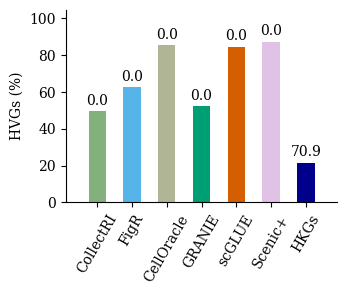

In [31]:
hvgs = hvgs_sce



def plot_bar(ax, data, y_label, pr_dict=None):
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    colors = [COLORS[surragate_names.get(key, key)] for key in data.keys()]
    
    x_range = [x for x in range(len(data))]
    y_values = list(data.values())
    ax.bar(x_range, y_values, width=width, color=colors, label='SCRE')
    ax.set_xticks(x_range)
    ax.set_xticklabels(data.keys())
    ax.tick_params(axis='x', rotation=60)
    ax.margins(x=.1, y=.2)
    ax.set_ylabel(y_label)
    if pr_dict is None:
        return 
    for i_text, value in enumerate(pr_dict.values()):
        # if value < 0.0001:
        #     txt = '***'
        # if value < 0.001:
        #     txt = '**'
        # elif value < 0.01:
        #     txt = '*'
        # else:
        #     txt = ''
        txt = f'{value}'
        ax.text(x_range[i_text], y_values[i_text] + 2, txt, ha='center', va='bottom')

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), sharey=False)

width = .5
# ax = axes[0]
plot_bar(ax, n_included_hvgs_dict, y_label='HVGs (%)', pr_dict=pr_dict)
# ax.set_title('(a) Number of HGVs')

# ax = axes[1]
# plot_bar(ax, n_included_hvgs_ratio_dict, y_label='HVGs per gene (ratio)')
# ax.set_title('(b) Ratio of HGVs')

# axes[1].legend(loc='upper left', bbox_to_anchor=(1,1), frameon=True)

# plt.tight_layout()
fig.savefig(f'{results_folder}/explanatory_analysis//figs/hvgs_stats.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()